# 이상치 유지(제거 X) 버전

# 1. 데이터 불러오기

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import Image

from model import *
from sklearn.tree import plot_tree

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings(action='ignore')

In [14]:
padua_data = pd.read_csv('../data/kideny_PADUA_upload.csv')
renal_data = pd.read_csv('../data/kideny_RENAL_upload.csv')
treat_data = pd.read_csv('../data/kidney_treat_upload.csv')

# 2. 데이터 정리
중복 컬럼 삭제(종양의 크기, 외성장 비율) 및 데이터 합치기

In [15]:
# padua_data, renal_data 데이터 merge
merged_data = pd.merge(padua_data, renal_data, on='serial')
# padua 에서 중복 컬럼 삭제
merged_data = merged_data.drop(['Tumor_PADUA', 'Exophytic_PADUA'], axis=1)
# treat 데이터 merge
merged_result = pd.merge(merged_data, treat_data, on='serial', how='left')
# serial을 인덱스로 설정
merged_result.set_index('serial', inplace=True)

In [16]:
merged_result = merged_result.rename(columns={'Radius_RENAL': 'T_size', 'Exophytic_RENAL':'T_exophytic',
                            'Rim_PADUA':'T_surface_loc','Polarlocation_PADUA':'T_height_loc',
                            'Collectingsystem_PADUA':'T_GM_over','Sinus_PADUA':'T_Sinus_dt',
                            'Nearness_RENAL':'T_near_Ureter','APX_RENAL':'T_APX','Location_RENAL':'T_rel_Ureter','RAIV_1': 'RAIV'
                            })

In [17]:
merged_result = merged_result.dropna()

In [18]:
merged_result['Total'] = merged_result[['PADUA_total', 'RENAL_total']].sum(axis=1)
merged_result.drop(columns=['PADUA_total', 'RENAL_total'], inplace=True)

In [19]:
# 새로운 컬럼(T_size + T_Exophytic = T_size_exo )
merged_result['T_size_exo'] = merged_result['T_size'] + merged_result['T_exophytic']

In [20]:
merged_result = merged_result[['T_surface_loc', 'T_Sinus_dt', 'T_height_loc', 'T_GM_over', 'T_size', 'T_exophytic', 'T_near_Ureter', 'T_rel_Ureter', 'T_APX', 'Total', 'T_size_exo', 'RAIV']]
merged_result

T_surface_loc  T_Sinus_dt  T_height_loc  T_GM_over  T_size  \
serial                                                               
1                 2.0         1.0           1.0        1.0     2.0   
2                 1.0         1.0           2.0        1.0     1.0   
3                 1.0         1.0           2.0        1.0     1.0   
4                 1.0         1.0           2.0        2.0     1.0   
5                 1.0         1.0           2.0        1.0     1.0   
...               ...         ...           ...        ...     ...   
408               1.0         1.0           2.0        1.0     1.0   
409               1.0         1.0           2.0        1.0     1.0   
410               1.0         1.0           1.0        1.0     1.0   
411               2.0         2.0           1.0        2.0     1.0   
412               1.0         1.0           2.0        1.0     1.0   

        T_exophytic  T_near_Ureter  T_rel_Ureter  T_APX  Total  T_size_exo  \
serial                                                                       
1               1.0            1.0           1.0    2.0     12         3.0   
2               2.0            2.0           2.0    2.0     13         3.0   
3               1.0            1.0           1.0    1.0     10         2.0   
4               1.0            3.0           3.0    2.0     13         2.0   
5               2.0            1.0           3.0    1.0     12         3.0   
...             ...            ...           ...    ...    ...         ...   
408             2.0            1.0           3.0    1.0     12         3.0   
409             2.0            1.0           3.0    1.0     12         3.0   
410             2.0            1.0           1.0    1.0     11         3.0   
411             2.0            2.0           1.0    2.0     15         3.0   
412             1.0            1.0           3.0    1.0     10         2.0   

        RAIV  
serial        
1       51.1  
2       46.1  
3       14.8  
4       19.7  
5       14.8  
...      ...  
408     21.3  
409     30.5  
410     70.7  
411     12.6  
412     11.8  

[389 rows x 12 columns]

In [21]:
merged_result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 389 entries, 1 to 412
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   T_surface_loc  389 non-null    float64
 1   T_Sinus_dt     389 non-null    float64
 2   T_height_loc   389 non-null    float64
 3   T_GM_over      389 non-null    float64
 4   T_size         389 non-null    float64
 5   T_exophytic    389 non-null    float64
 6   T_near_Ureter  389 non-null    float64
 7   T_rel_Ureter   389 non-null    float64
 8   T_APX          389 non-null    float64
 9   Total          389 non-null    int64  
 10  T_size_exo     389 non-null    float64
 11  RAIV           389 non-null    float64
dtypes: float64(11), int64(1)
memory usage: 39.5 KB


RAIV80이상인 데이터없는 데이터 새로 만들어줌
(merged_data는 살려둠)

# 3. 모델링

## 01. 데이터 나누기(train_test_split)

In [22]:
X = merged_result.drop(['RAIV'], axis=1)  # 'RAIV_1' 열을 제외한 모든 열 선택
y = merged_result['RAIV']

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

- DecisionTreeRegressor

In [24]:
# 그리드 서치를 사용하여 최적의 하이퍼파라미터를 찾습니다
best_model_dt, best_params_dt = grid_search(X_train, y_train, "DecisionTreeRegressor")

# 최적의 하이퍼파라미터를 사용하여 모델을 훈련합니다
best_dt = tr_dt(X_train, y_train, **best_params_dt)

# 최적의 모델을 평가합니다
evaluate(best_dt, X_test, y_test)

MAE: 18.561264527586225
RMSE: 26.925755037420487


In [25]:
print(best_model_dt, best_params_dt)

DecisionTreeRegressor(max_depth=5, min_samples_split=30, random_state=13) {'max_depth': 5, 'min_samples_split': 30}


{'T_surface_loc': 0.03568426414712216, 'T_Sinus_dt': 0.010792613575743674, 'T_height_loc': 0.04428294652593326, 'T_GM_over': 0.129704530391726, 'T_size': 0.23608512652642824, 'T_exophytic': 0.0, 'T_near_Ureter': 0.2826861906011573, 'T_rel_Ureter': 0.20267186187286404, 'T_APX': 0.0, 'Total': 0.058092466359025506, 'T_size_exo': 0.0}


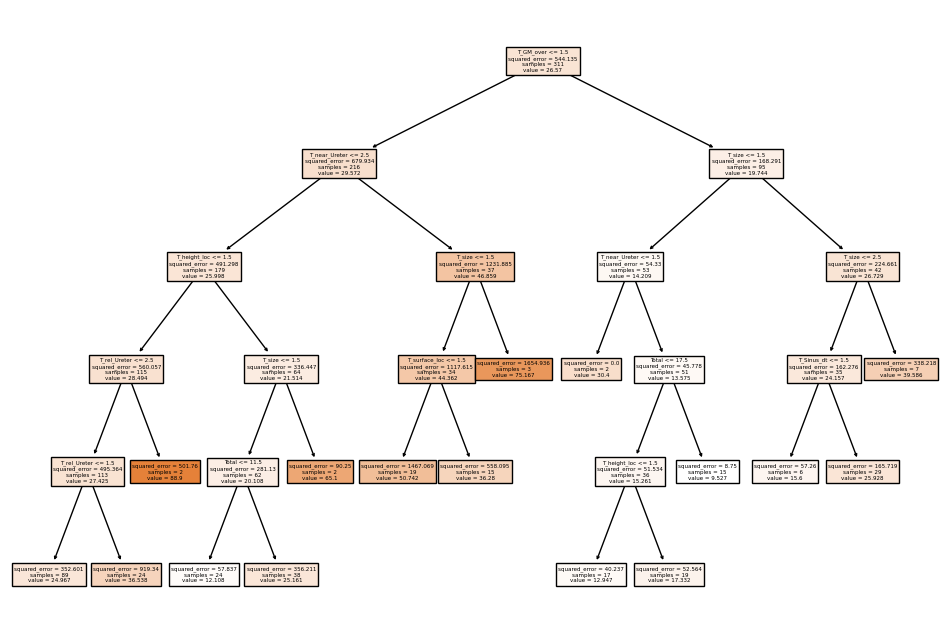

In [26]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# 특성 중요도를 확인합니다
feature_importances_dt = best_dt.feature_importances_
importances_dict = dict(zip(X_train.columns, feature_importances_dt))
print(importances_dict)

# 결정 트리를 시각화합니다
plt.figure(figsize=(12, 8))
plot_tree(best_dt, filled=True, feature_names=X.columns.tolist())
plt.show()

In [27]:
# dt에 따른 다중 선형회귀
# from sklearn.linear_model import LinearRegression
# import numpy as np

# # 중요 특성 선택
# X_important_features = merged_result[['T_size', 'T_rel_ureter', 'T_near_ureter', 'T_gm_over']]  # 중요 특성 값들로 이루어진 데이터

# # 종속 변수 값
# y = merged_result['RAIV']

# # 데이터 분할
# X_train, X_test, y_train, y_test = train_test_split(X_important_features, y, test_size=0.2, random_state=42)

# # 모델 학습
# lr_model = LinearRegression()
# lr_model.fit(X_train, y_train)

# # 최적의 모델을 평가
# evaluate(lr_model, X_test, y_test)

In [28]:
# # 다항회귀쓰는 법  -> 특성 선택(feature selection)이나 차원 축소(dimensionality reduction) 기법을 사용하여 알고리즘이 사용할 독립 변수의 수를 제한 / 차수 선택가능
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.linear_model import LinearRegression
# from sklearn.pipeline import make_pipeline

# # 데이터 생성
# X = [[1], [2], [3], [4], [5]]  # 독립 변수
# y = [2, 3, 5, 6, 5]            # 종속 변수

# # 다항 특성 생성
# degree = 2  # 다항식의 차수
# poly = PolynomialFeatures(degree)
# X_poly = poly.fit_transform(X)

# # 모델 학습
# model = LinearRegression()
# model.fit(X_poly, y)

# # 모델 평가 및 활용
# # 이후에 새로운 데이터에 대한 예측을 수행하거나 모델을 활용하여 분석을 진행할 수 있습니다.

- RandomForestRegressor

In [29]:
# 그리드 서치를 사용하여 최적의 하이퍼파라미터를 찾습니다
best_model_rf, best_params_rf = grid_search(X_train, y_train, "RandomForestRegressor")

# 최적의 하이퍼파라미터를 사용하여 모델 훈련합니다
best_rf = tr_rf(X_train, y_train, **best_params_rf)

# 최적의 모델을 평가
evaluate(best_rf, X_test, y_test)

MAE: 17.844120131033492
RMSE: 26.320437953413077


In [30]:
print(best_model_rf, best_params_rf)

RandomForestRegressor(max_depth=5, min_samples_split=20, n_estimators=50,
                      random_state=13) {'max_depth': 5, 'min_samples_split': 20, 'n_estimators': 50}


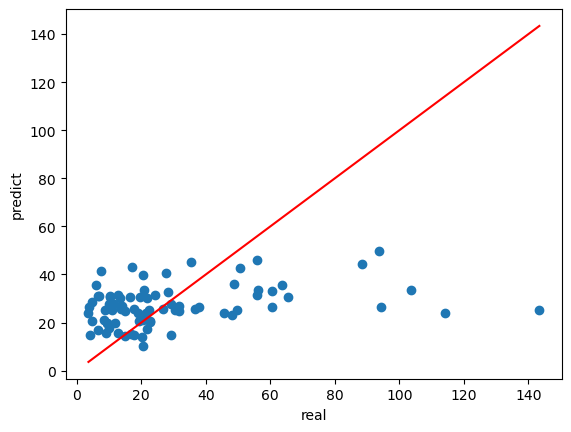

In [31]:
# 최적의 모델을 평가합니다
predictions = best_rf.predict(X_test)

# 산점도를 그립니다
plt.scatter(y_test, predictions)
plt.xlabel('real')
plt.ylabel('predict')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r') 
plt.show()

In [32]:
# 각 특성과 해당 중요도를 딕셔너리 형태로 출력합니다
importances_dict = dict(zip(X_train.columns, best_rf.feature_importances_))
print(importances_dict)

{'T_surface_loc': 0.04419063035018332, 'T_Sinus_dt': 0.025903300433504087, 'T_height_loc': 0.06969954503162544, 'T_GM_over': 0.13619909278742195, 'T_size': 0.12044575164604202, 'T_exophytic': 0.046664237690790755, 'T_near_Ureter': 0.2338108088750408, 'T_rel_Ureter': 0.10644027100429002, 'T_APX': 0.033163771835955314, 'Total': 0.15232064172789944, 'T_size_exo': 0.031161948617246846}


- KNeighborsRegressor

In [33]:
# 그리드 서치를 사용하여 최적의 하이퍼파라미터를 찾습니다
best_model_knn, best_params_knn = grid_search(X_train, y_train, "KNeighborsRegressor")

# 최적의 하이퍼파라미터를 사용하여 모델을 훈련합니다
best_knn = tr_knn(X_train, y_train, **best_params_knn)

# 최적의 모델을 평가합니다
evaluate(best_knn, X_test, y_test)

MAE: 19.022692307692306
RMSE: 26.644944991306392


In [34]:
print(best_model_knn, best_params_knn)

KNeighborsRegressor(n_neighbors=10) {'n_neighbors': 10, 'weights': 'uniform'}


- XGBRegressor

In [35]:
# 그리드 서치를 사용하여 최적의 하이퍼파라미터를 찾습니다
best_model_xgb, best_params_xgb = grid_search(X_train, y_train, "XGBoostRegressor")

# 최적의 하이퍼파라미터를 사용하여 모델을 훈련합니다
best_xgb = tr_xgb(X_train, y_train, **best_params_xgb)

# 최적의 모델을 평가합니다
evaluate(best_xgb, X_test, y_test)

MAE: 17.741839381976007
RMSE: 26.618883493133453


In [36]:
print(best_model_xgb, best_params_xgb)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=13, ...) {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50}


- AdaBoostRegressor

In [37]:
# 그리드 서치를 사용하여 최적의 하이퍼파라미터를 찾습니다
best_model_ada, best_params_ada = grid_search(X_train, y_train, "AdaBoostRegressor")

# 최적의 하이퍼파라미터를 사용하여 모델을 훈련합니다
best_ada = tr_adaboost(X_train, y_train, **best_params_ada)

# 최적의 모델을 평가합니다
evaluate(best_ada, X_test, y_test)

MAE: 18.458908661406866
RMSE: 26.652780947784805


In [38]:
print(best_model_ada, best_params_ada)

AdaBoostRegressor(learning_rate=0.05, random_state=13) {'learning_rate': 0.05, 'n_estimators': 50}


- LGBMRegressor

In [39]:
# 그리드 서치를 사용하여 최적의 하이퍼파라미터를 찾습니다
best_model_lgb, best_params_lgb = grid_search(X_train, y_train, "LightGBM")

# 최적의 하이퍼파라미터를 사용하여 모델을 훈련합니다
best_lgb = tr_lgb(X_train, y_train, **best_params_lgb)

# 최적의 모델을 평가합니다
evaluate(best_lgb, X_test, y_test)

Exception in thread Thread-6:
Traceback (most recent call last):
  File "c:\Users\rbfl7\miniconda3\envs\ds_study\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "c:\Users\rbfl7\miniconda3\envs\ds_study\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\rbfl7\miniconda3\envs\ds_study\lib\subprocess.py", line 1386, in _readerthread
    buffer.append(fh.read())
  File "c:\Users\rbfl7\miniconda3\envs\ds_study\lib\codecs.py", line 322, in decode
    (result, consumed) = self._buffer_decode(data, self.errors, final)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb1 in position 24: invalid start byte


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 51
[LightGBM] [Info] Number of data points in the train set: 248, number of used features: 11
[LightGBM] [Info] Start training from score 26.495564
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

  File "c:\Users\rbfl7\miniconda3\envs\ds_study\lib\site-packages\joblib\externals\loky\backend\context.py", line 202, in _count_physical_cores
    cpu_info = cpu_info.stdout.splitlines()


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [40]:
print(best_model_lgb, best_params_lgb)

LGBMRegressor(learning_rate=0.05, max_depth=3, n_estimators=50, random_state=13) {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50}


- GradientBoostingRegressor

In [41]:
# 그리드 서치를 사용하여 최적의 하이퍼파라미터를 찾습니다
best_model_gbm, best_params_gbm = grid_search(X_train, y_train, "GradientBoostingRegressor")

# 최적의 하이퍼파라미터를 사용하여 모델을 훈련합니다
best_gbm = tr_gbm(X_train, y_train, **best_params_gbm)

# 최적의 모델을 평가합니다
evaluate(best_gbm, X_test, y_test)

MAE: 17.825851075068844
RMSE: 26.6294761451367


In [42]:
print(best_model_gbm, best_params_gbm)

GradientBoostingRegressor(learning_rate=0.05, n_estimators=50, random_state=13) {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50}


## X 데이터(RAIV X)로 군집 0 과 1로 나눔 (이상치가 포함됨)

In [43]:
cluster_range = range(2, 11)

optimal_clusters = 0
max_silhouette_score = -1

for n_clusters in cluster_range:
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=13)
    
    kmeans.fit(X)
    
    clusters = kmeans.predict(X)
    
    silhouette_avg = silhouette_score(X, clusters)
    
    if silhouette_avg > max_silhouette_score:
        max_silhouette_score = silhouette_avg
        optimal_clusters = n_clusters

# Print the optimal number of clusters
print("Optimal number of clusters:", optimal_clusters)

Optimal number of clusters: 2


In [44]:
kmeans = KMeans(n_clusters=2, random_state=13)
kmeans.fit(X)

cluster = kmeans.predict(X)          # X데이터 군집화
labels = kmeans.labels_           # 군집 레이블 생성

print('cluster_labels :', cluster)

cluster_labels : [0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 1 0 0 1 0 0 1 0 0 1 1 1 0 0 1 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1
 0 1 1 0 1 1 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0
 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 0 1
 0 0 1 0 0 1 1 0 0 0 0 1 0 1 0 0 1 1 1 0 1 0 0 1 1 0 1 1 1 1 1 1 1 0 0 1 1
 1 1 0 1 1 1 1 0 0 0 1 1 0 1 0 1 0 0 1 1 1 1 0 0 0 1 1 0 1 1 1 0 0 1 0 1 1
 0 1 1 1 1 1 0 0 1 0 1 0 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 0 0 0
 0 1 1 0 0 0 1 1 0 1 0 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 0 1 1 0 1
 1 0 0 1 1 0 0 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 0 1 0 1 1 0 1
 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0
 1 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0]


In [45]:
# 군집0
X_0 = X[labels == 0]
y_0 = y[labels == 0]

#군집1
X_1 = X[labels == 1]
y_1 = y[labels == 1]

## 군집 0 데이터 나누기

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_0, y_0, test_size=0.2, random_state=13)

- DecisionTreeRegressor

In [47]:
# 그리드 서치를 사용하여 최적의 하이퍼파라미터를 찾습니다
best_model_dt, best_params_dt = grid_search(X_train, y_train, "DecisionTreeRegressor")

# 최적의 하이퍼파라미터를 사용하여 모델을 훈련합니다
best_dt = tr_dt(X_train, y_train, **best_params_dt)

# 최적의 모델을 평가합니다
evaluate(best_dt, X_test, y_test)

MAE: 14.575205334230482
RMSE: 20.96464085059644


- RandomForestRegressor

In [48]:
# 그리드 서치를 사용하여 최적의 하이퍼파라미터를 찾습니다
best_model_rf, best_params_rf = grid_search(X_train, y_train, "RandomForestRegressor")

# 최적의 하이퍼파라미터를 사용하여 모델 훈련합니다
best_rf = tr_rf(X_train, y_train, **best_params_rf)

# 최적의 모델을 평가
evaluate(best_rf, X_test, y_test)

MAE: 16.135997595301905
RMSE: 22.319935104161207


- KNeighborsRegressor

In [49]:
# 그리드 서치를 사용하여 최적의 하이퍼파라미터를 찾습니다
best_model_knn, best_params_knn = grid_search(X_train, y_train, "KNeighborsRegressor")

# 최적의 하이퍼파라미터를 사용하여 모델을 훈련합니다
best_knn = tr_knn(X_train, y_train, **best_params_knn)

# 최적의 모델을 평가합니다
evaluate(best_knn, X_test, y_test)

MAE: 14.152439024390244
RMSE: 21.218804993822197


- XGBRegressor

In [50]:
# 그리드 서치를 사용하여 최적의 하이퍼파라미터를 찾습니다
best_model_xgb, best_params_xgb = grid_search(X_train, y_train, "XGBoostRegressor")

# 최적의 하이퍼파라미터를 사용하여 모델을 훈련합니다
best_xgb = tr_xgb(X_train, y_train, **best_params_xgb)

# 최적의 모델을 평가합니다
evaluate(best_xgb, X_test, y_test)

MAE: 12.69380625282846
RMSE: 20.443346976966293


- AdaBoostRegressor

In [51]:
# 그리드 서치를 사용하여 최적의 하이퍼파라미터를 찾습니다
best_model_ada, best_params_ada = grid_search(X_train, y_train, "AdaBoostRegressor")

# 최적의 하이퍼파라미터를 사용하여 모델을 훈련합니다
best_ada = tr_adaboost(X_train, y_train, **best_params_ada)

# 최적의 모델을 평가합니다
evaluate(best_ada, X_test, y_test)

MAE: 15.019514758592234
RMSE: 21.248029147588916


- LGBMRegressor

In [52]:
# 그리드 서치를 사용하여 최적의 하이퍼파라미터를 찾습니다
best_model_lgb, best_params_lgb = grid_search(X_train, y_train, "LightGBM")

# 최적의 하이퍼파라미터를 사용하여 모델을 훈련합니다
best_lgb = tr_lgb(X_train, y_train, **best_params_lgb)

# 최적의 모델을 평가합니다
evaluate(best_lgb, X_test, y_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31
[LightGBM] [Info] Number of data points in the train set: 131, number of used features: 8
[LightGBM] [Info] Start training from score 29.296183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

- GradientBoostingRegressor

In [53]:
# 그리드 서치를 사용하여 최적의 하이퍼파라미터를 찾습니다
best_model_gbm, best_params_gbm = grid_search(X_train, y_train, "GradientBoostingRegressor")

# 최적의 하이퍼파라미터를 사용하여 모델을 훈련합니다
best_gbm = tr_gbm(X_train, y_train, **best_params_gbm)

# 최적의 모델을 평가합니다
evaluate(best_gbm, X_test, y_test)

MAE: 14.549013434095597
RMSE: 21.14706179580394


## 군집 1 데이터 나누기

In [54]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.2, random_state=13)

- DecisionTreeRegressor

In [55]:
# 그리드 서치를 사용하여 최적의 하이퍼파라미터를 찾습니다
best_model_dt, best_params_dt = grid_search(X_train, y_train, "DecisionTreeRegressor")

# 최적의 하이퍼파라미터를 사용하여 모델을 훈련합니다
best_dt = tr_dt(X_train, y_train, **best_params_dt)

# 최적의 모델을 평가합니다
evaluate(best_dt, X_test, y_test)

MAE: 15.457346112346112
RMSE: 22.92932406160365


- RandomForestRegressor

In [56]:
# 그리드 서치를 사용하여 최적의 하이퍼파라미터를 찾습니다
best_model_rf, best_params_rf = grid_search(X_train, y_train, "RandomForestRegressor")

# 최적의 하이퍼파라미터를 사용하여 모델 훈련합니다
best_rf = tr_rf(X_train, y_train, **best_params_rf)

# 최적의 모델을 평가
evaluate(best_rf, X_test, y_test)

MAE: 16.157050517436712
RMSE: 22.87737626562823


- KNeighborsRegressor

In [57]:
# 그리드 서치를 사용하여 최적의 하이퍼파라미터를 찾습니다
best_model_knn, best_params_knn = grid_search(X_train, y_train, "KNeighborsRegressor")

# 최적의 하이퍼파라미터를 사용하여 모델을 훈련합니다
best_knn = tr_knn(X_train, y_train, **best_params_knn)

# 최적의 모델을 평가합니다
evaluate(best_knn, X_test, y_test)

MAE: 15.792297297297296
RMSE: 23.524509458653334


- XGBRegressor

In [58]:
# 그리드 서치를 사용하여 최적의 하이퍼파라미터를 찾습니다
best_model_xgb, best_params_xgb = grid_search(X_train, y_train, "XGBoostRegressor")

# 최적의 하이퍼파라미터를 사용하여 모델을 훈련합니다
best_xgb = tr_xgb(X_train, y_train, **best_params_xgb)

# 최적의 모델을 평가합니다
evaluate(best_xgb, X_test, y_test)

MAE: 15.982962860932224
RMSE: 23.884064559783873


- AdaBoostRegressor

In [59]:
# 그리드 서치를 사용하여 최적의 하이퍼파라미터를 찾습니다
best_model_ada, best_params_ada = grid_search(X_train, y_train, "AdaBoostRegressor")

# 최적의 하이퍼파라미터를 사용하여 모델을 훈련합니다
best_ada = tr_adaboost(X_train, y_train, **best_params_ada)

# 최적의 모델을 평가합니다
evaluate(best_ada, X_test, y_test)

MAE: 17.0889386225779
RMSE: 24.43195960417938


- LGBMRegressor

In [60]:
# 그리드 서치를 사용하여 최적의 하이퍼파라미터를 찾습니다
best_model_lgb, best_params_lgb = grid_search(X_train, y_train, "LightGBM")

# 최적의 하이퍼파라미터를 사용하여 모델을 훈련합니다
best_lgb = tr_lgb(X_train, y_train, **best_params_lgb)

# 최적의 모델을 평가합니다
evaluate(best_lgb, X_test, y_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45
[LightGBM] [Info] Number of data points in the train set: 117, number of used features: 11
[LightGBM] [Info] Start training from score 27.728205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

- GradientBoostingRegressor

In [61]:
# 그리드 서치를 사용하여 최적의 하이퍼파라미터를 찾습니다
best_model_gbm, best_params_gbm = grid_search(X_train, y_train, "GradientBoostingRegressor")

# 최적의 하이퍼파라미터를 사용하여 모델을 훈련합니다
best_gbm = tr_gbm(X_train, y_train, **best_params_gbm)

# 최적의 모델을 평가합니다
evaluate(best_gbm, X_test, y_test)

MAE: 16.561530132772205
RMSE: 24.690329900369264
